In [66]:
#makes sure to reload our modules on each execution

%load_ext autoreload 
%autoreload 1
%aimport gans, preprocessing, sourceSeparation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# generates preprocessed datasets for our models

batchSize = 64
noiseDim = 200

loader1, loader2, loader_mix_val, vallabel, loader_mix_test, testlabel = preprocessing.gen_loaders(
    noiseDim, 
    batchSize
)

tensor([[-5.2333e+00,  8.0104e+00, -6.5414e+00,  ..., -1.6264e-02,
         -9.4920e-03, -2.6615e-03],
        [ 7.2181e+00, -5.5538e-01, -5.2231e+00,  ...,  5.3492e-03,
          3.7846e-03,  1.0183e-03],
        [ 7.0104e+00, -4.4593e+00,  1.0834e+00,  ...,  3.4616e-03,
          6.2277e-03,  2.3342e-03],
        ...,
        [ 5.1488e+00, -4.4116e+00, -4.4524e+00,  ..., -5.8865e-03,
         -5.2385e-03, -6.0438e-04],
        [ 2.5583e+01, -1.4009e+01,  4.4025e+00,  ...,  9.2564e-03,
          5.7815e-03, -3.7460e-04],
        [-6.2106e-01, -9.6807e-02, -4.9533e+00,  ..., -7.5889e-04,
          6.9582e-04, -3.4315e-04]])


Spike generator training


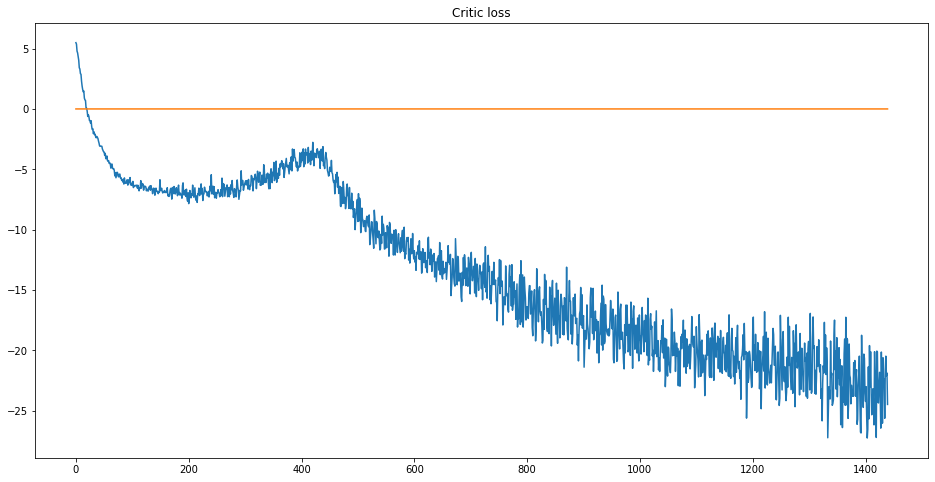

Critic loss -24.48366355895996

Epoch 9

Generated example:


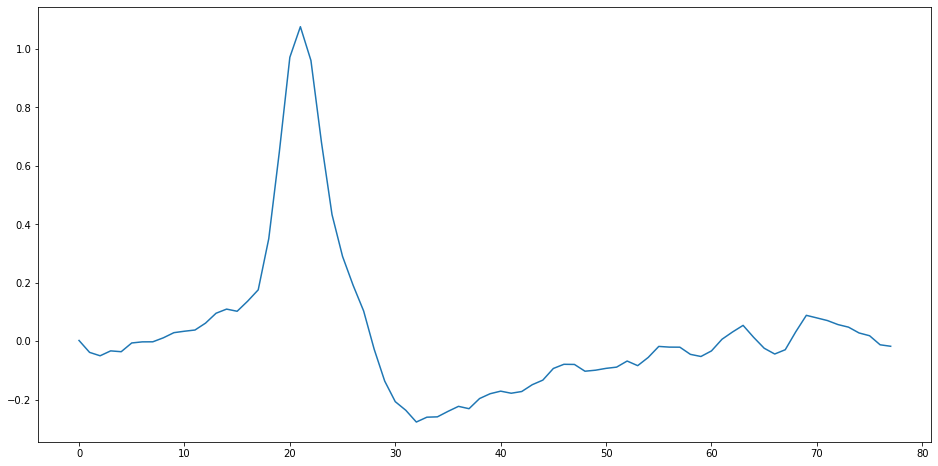

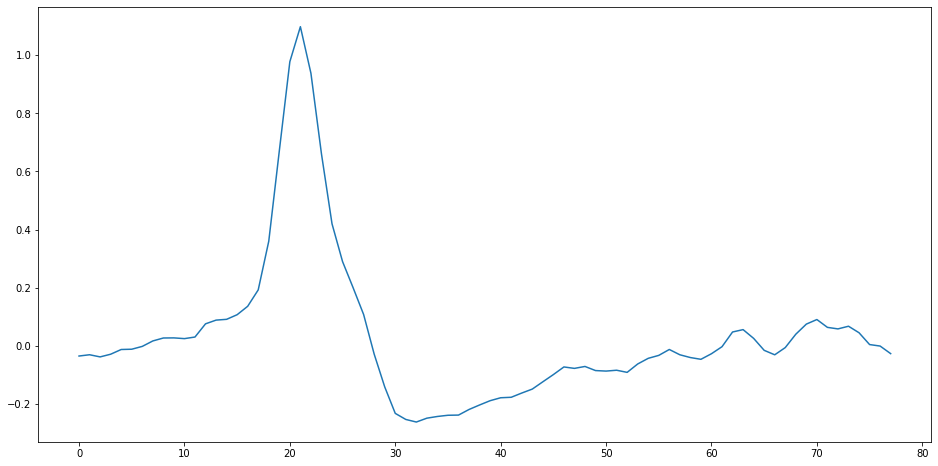

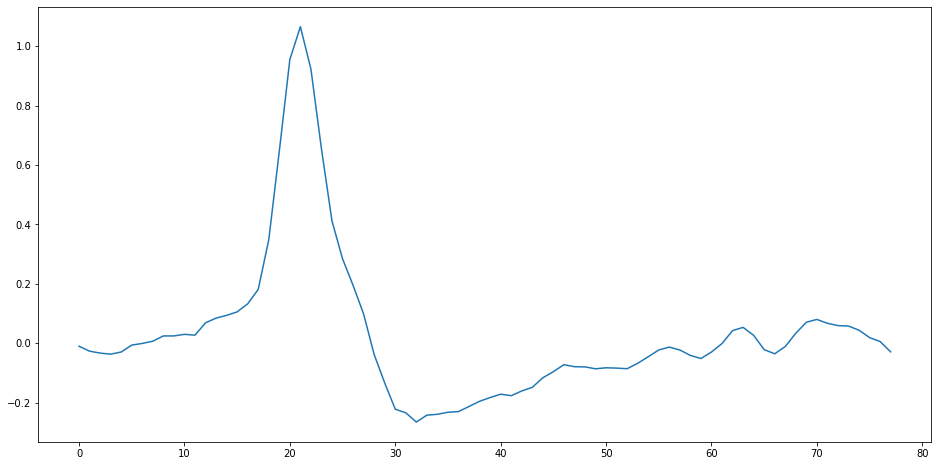

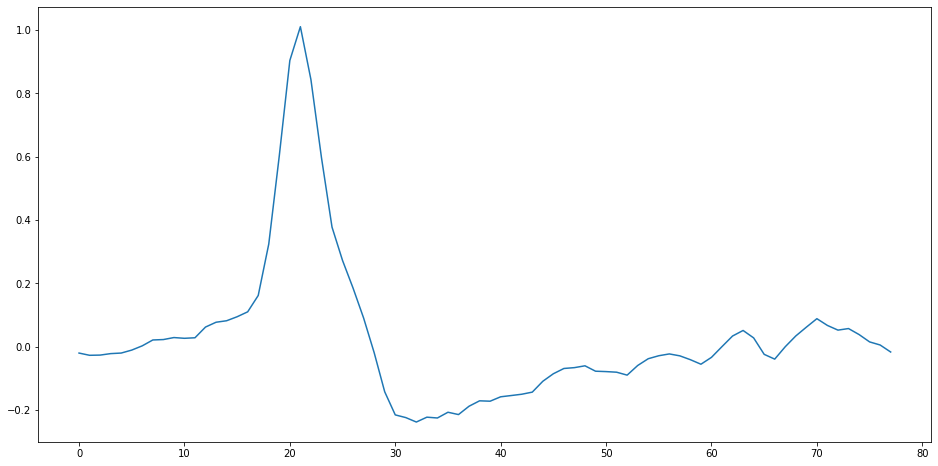

In [4]:
# declares and trains the gan for spikes 

gen1 = gans.Generator(inputSize=noiseDim, hiddenSize=40, outputSize=80)
critic1 = gans.Critic(inputSize=80, hiddenSize=40)

print("Spike generator training")

gans.adversarial_trainer( 
    train_loader = loader1,
    generator = gen1, 
    critic = critic1, 
    batchSize = batchSize,
    noiseDim = noiseDim,
    epochs = 10,
    printEpochs = 10,
)

Background generator training


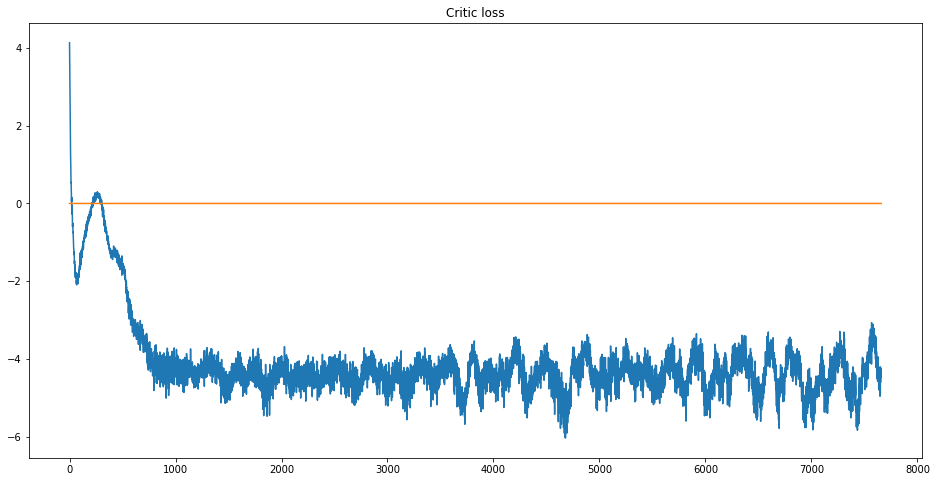

Critic loss -4.263462066650391

Epoch 2

Generated example:


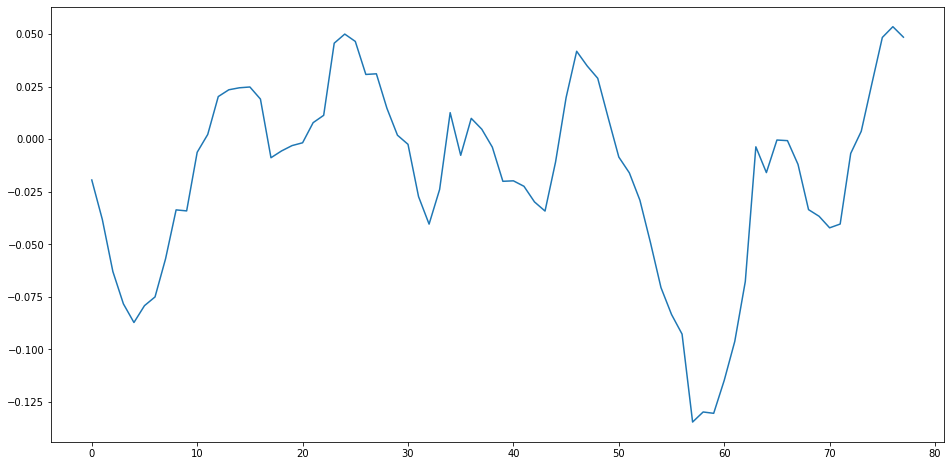

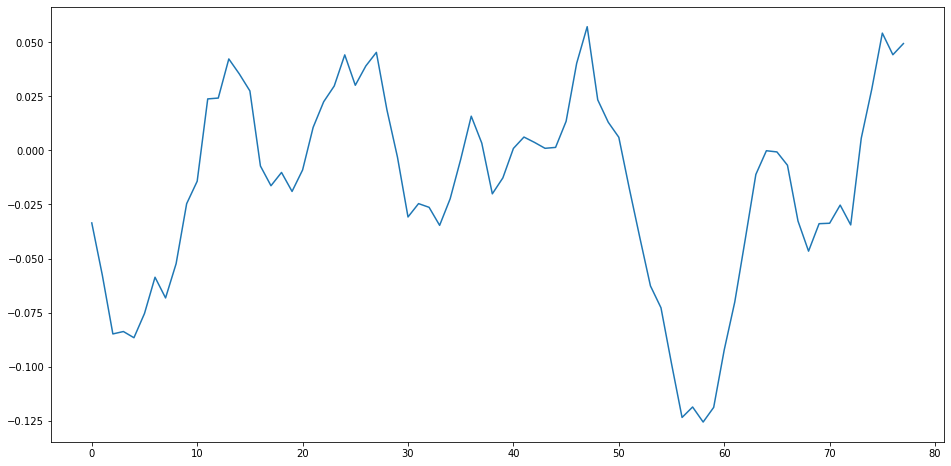

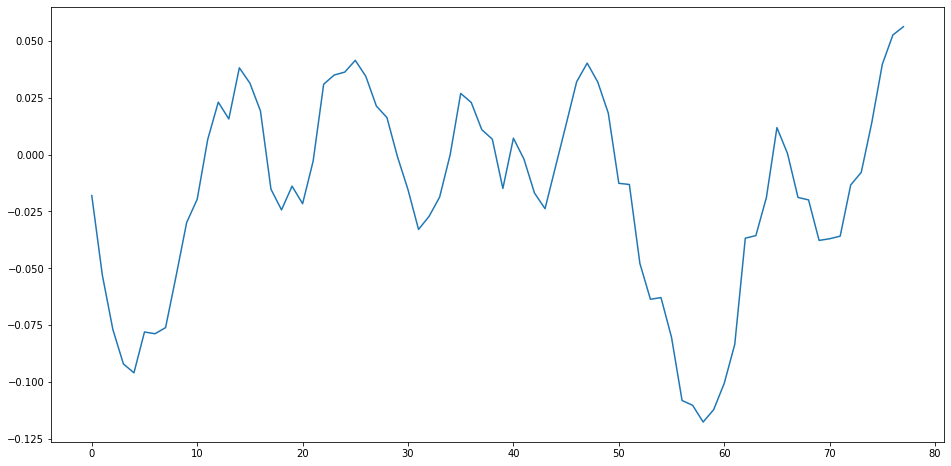

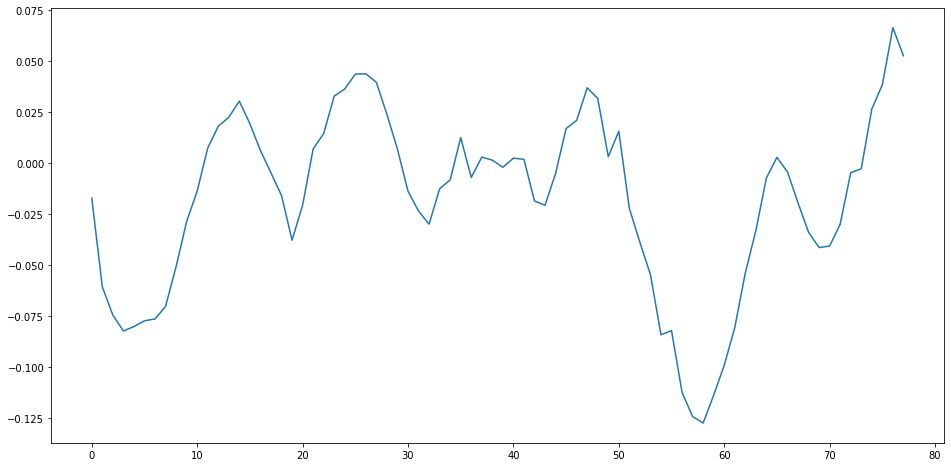

In [5]:
# declares and trains the gan for hash

gen2 = gans.Generator(inputSize=noiseDim, hiddenSize=40, outputSize=80)
critic2 = gans.Critic(inputSize=80, hiddenSize=40)
print("Background generator training")

gans.adversarial_trainer( 
    train_loader = loader2,
    generator = gen2, 
    critic = critic2, 
    batchSize = batchSize,
    noiseDim = noiseDim,
    epochs = 3,
    printEpochs = 3
)

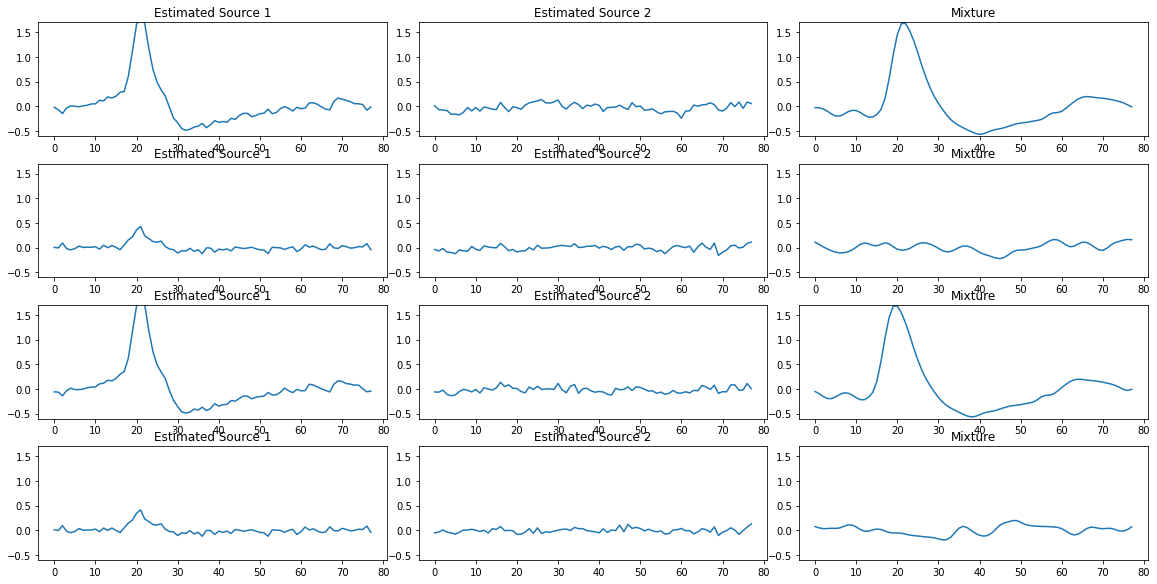

In [7]:
# separates the samples from loader_mix_val

(cleanextractedSpikesValidation,cleanextractedNoisesValidation) = sourceSeparation.maxlikelihood_separatesources(
    generators=[gen1, gen2],
    loader_mix=loader_mix_val,
    epochs=1000
)

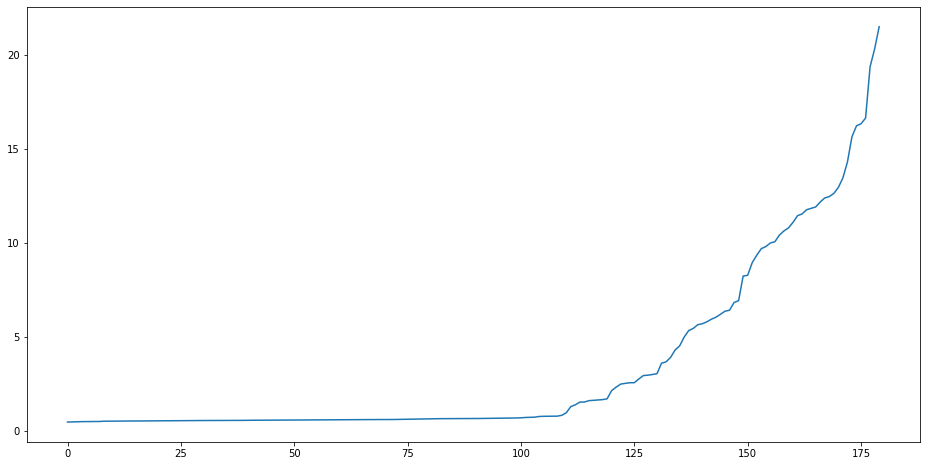

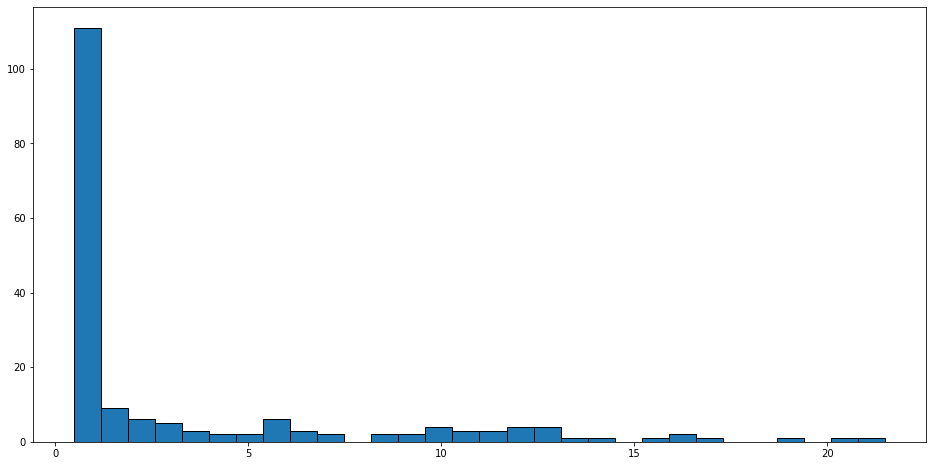

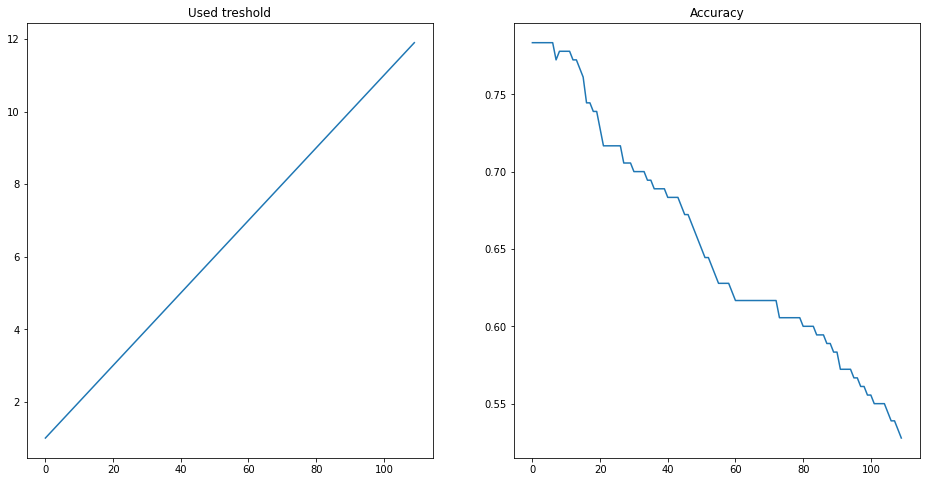

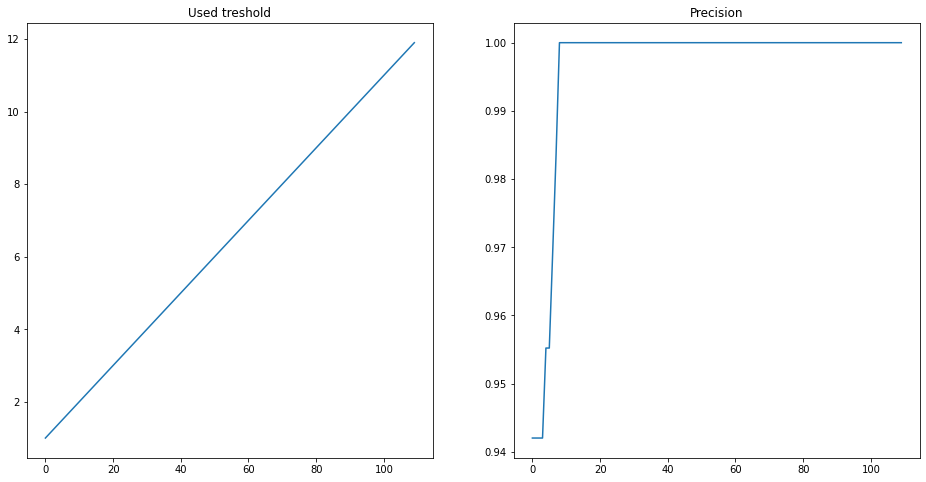

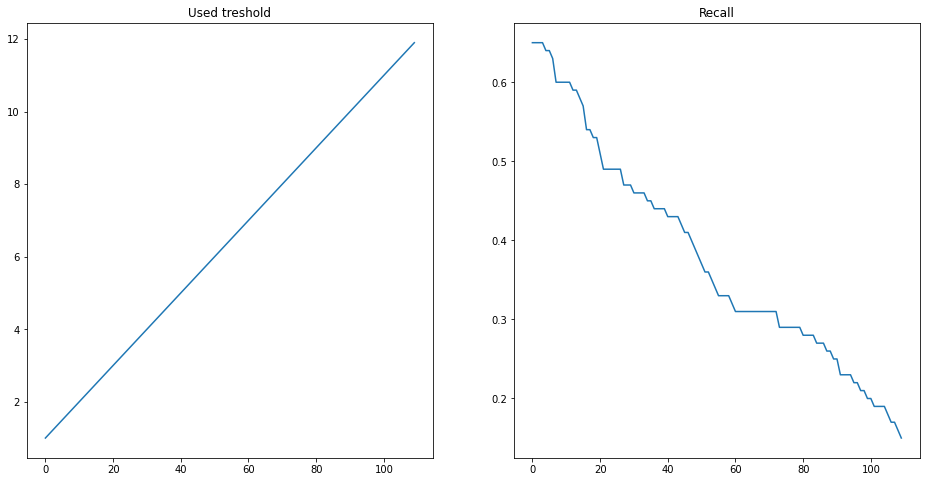

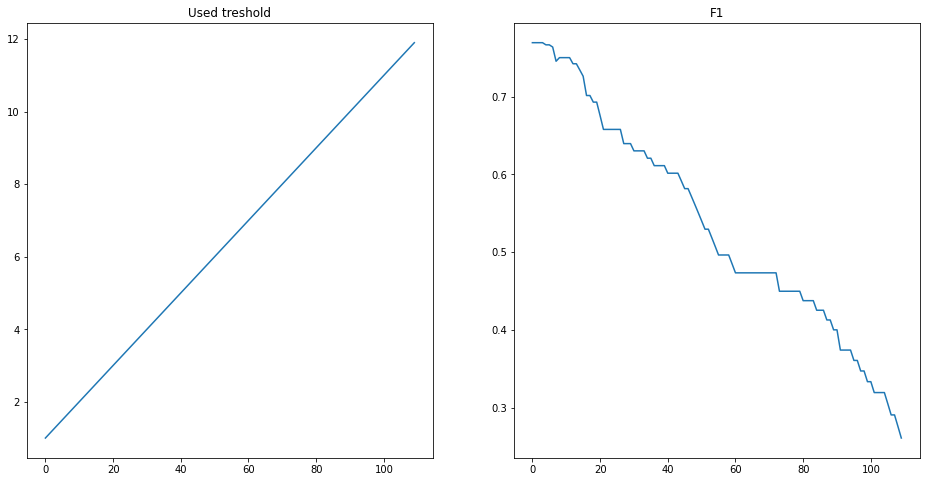

Threshold for best F1: 1.0
Threshold: 1.0
Precision: 0.9420289855072463
Recall: 0.65
F1: 0.7692307692307692
Accuracy: 0.7833333333333333


In [8]:
# some interpretation of results

import numpy as np
import torch
import matplotlib.pyplot as plt


extractedSpikesValidation = np.array(cleanextractedSpikesValidation)
energy = []

for extractedSpike in extractedSpikesValidation:
    energy.append(sum(np.power(extractedSpike, 2)))

energy = np.array(energy)
hist, edges = np.histogram(energy, bins = 30)

plt.plot(np.sort(energy))
plt.show()
plt.bar(edges[:-1], hist, width=np.diff(edges), edgecolor="black", align="edge")
plt.show()

thresholds =  [x / 10 for x in range(10,120,1)]

precisions = []
recalls = []
f1s = []
accs = []
used = []

for threshold in thresholds:
    try:
        res = []

        for elem in energy:
            if elem > threshold:
                res.append(1)
            else:
                res.append(0)

        truepos = 0
        falsepos = 0
        trueneg = 0
        falseneg = 0

        for i in range(0, len(vallabel)):
            if (
                vallabel[i] == 1 or 
                vallabel[i - 1] == 1 or 
                vallabel[i - 2] == 1 or 
                i + 1 < 180 and vallabel[i + 1] == 1 or 
                i + 2 < 180 and vallabel[i + 2] == 1
            ):
                if res[i] == 1:
                    truepos += 1
                else:
                    falseneg += 1
            else:
                if res[i] == 1:
                    falsepos += 1
                else:
                    trueneg += 1

        precision = truepos / (truepos + falsepos)
        recall = truepos / (truepos + falseneg)  
        f1 = 2 * ((precision * recall)/(precision+recall))
        acc = (truepos + trueneg) / len(vallabel)

        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
        accs.append(acc)
        used.append(threshold)
    except:
        continue
    
_, axs = plt.subplots(1,2)
axs[0].plot(used)
axs[0].title.set_text("Used treshold")
axs[1].plot(accs)
axs[1].title.set_text("Accuracy")
plt.show()
_, axs = plt.subplots(1,2)
axs[0].plot(used)
axs[0].title.set_text("Used treshold")
axs[1].plot(precisions)
axs[1].title.set_text("Precision")
plt.show()
_, axs = plt.subplots(1,2)
axs[0].plot(used)
axs[0].title.set_text("Used treshold")
axs[1].plot(recalls)
axs[1].title.set_text("Recall")
plt.show()
_, axs = plt.subplots(1,2)
axs[0].plot(used)
axs[0].title.set_text("Used treshold")
axs[1].plot(f1s)
axs[1].title.set_text("F1")
plt.show()

f1max = f1s[0]
maxI = 0

for i,f in enumerate(f1s):
    if f > f1max:
        maxI = i
        f1max = f
print("Threshold for best F1: {}".format(used[maxI]))
res = []
threshold = used[maxI]
print("Threshold: {}".format(threshold))

for elem in energy:
    if elem > threshold:
        res.append(1)
    else:
        res.append(0)

truepos = 0
falsepos = 0
trueneg = 0
falseneg = 0

for i in range(0, len(vallabel)):
    if (
        vallabel[i] == 1 or 
        vallabel[i - 1] == 1 or 
        vallabel[i - 2] == 1 or 
        i + 1 < 180 and vallabel[i + 1] == 1 or 
        i + 2 < 180 and vallabel[i + 2] == 1
    ):
        if res[i] == 1:
            truepos += 1
        else:
            falseneg += 1
    else:
        if res[i] == 1:
            falsepos += 1
        else:
            trueneg += 1

precision = truepos / (truepos + falsepos)
recall = truepos / (truepos + falseneg)  
f1 = 2 * ((precision * recall)/(precision+recall))
acc = (truepos + trueneg) / len(vallabel)

print("Precision: {}".format(precision))
print("Recall: {}".format(recall))
print("F1: {}".format(f1))
print("Accuracy: {}".format(acc))

NameError: name 'Dataset' is not defined

In [191]:
featureDataLoader=gans.getFeatures(cleanextractedSpikesValidation,cleanextractedNoisesValidation)
model=gans.binaryClassification()
model.to(device)

gans.classifiyTrain(
train_loader=featureDataLoader,
labels=labels,
epoch=50,
model=model,
device=device
)



[tensor([[13.4463,  2.0038, 30.5777],
        [ 2.0038, 30.5777, 13.9221],
        [30.5777, 13.9221,  2.8645],
        [13.9221,  2.8645, 49.0381],
        [ 2.8645, 49.0381, 13.8862],
        [49.0381, 13.8862,  3.5558],
        [13.8862,  3.5558, 52.0898],
        [ 3.5558, 52.0898, 10.5593],
        [52.0898, 10.5593,  2.7663],
        [10.5593,  2.7663, 31.3324],
        [ 2.7663, 31.3324,  9.5593],
        [31.3324,  9.5593,  2.4890],
        [ 9.5593,  2.4890, 24.1725],
        [ 2.4890, 24.1725,  4.7643],
        [24.1725,  4.7643,  0.8626],
        [ 4.7643,  0.8626,  3.0935],
        [ 0.8626,  3.0935,  4.1139],
        [ 3.0935,  4.1139,  0.8208]]), tensor([1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0.])]
[tensor([[4.1139, 0.8208, 2.8380],
        [0.8208, 2.8380, 3.8228],
        [2.8380, 3.8228, 0.7820],
        [3.8228, 0.7820, 2.7390],
        [0.7820, 2.7390, 3.6192],
        [2.7390, 3.6192, 0.8143],
        [3.6192, 0.8143, 3.0485],
        [0

Epoch 012: | Loss: 0.44813 | Acc: 81.100
Epoch 013: | Loss: 0.44165 | Acc: 81.100
Epoch 014: | Loss: 0.43575 | Acc: 80.400
Epoch 015: | Loss: 0.43479 | Acc: 81.700
Epoch 016: | Loss: 0.41978 | Acc: 83.700
Epoch 017: | Loss: 0.41774 | Acc: 79.300
Epoch 018: | Loss: 0.39547 | Acc: 83.200
Epoch 019: | Loss: 0.39825 | Acc: 82.100
Epoch 020: | Loss: 0.39102 | Acc: 84.400
Epoch 021: | Loss: 0.39192 | Acc: 81.400
Epoch 022: | Loss: 0.38190 | Acc: 83.900
Epoch 023: | Loss: 0.36636 | Acc: 83.200
Epoch 024: | Loss: 0.36500 | Acc: 85.500
Epoch 025: | Loss: 0.36322 | Acc: 83.700
Epoch 026: | Loss: 0.36219 | Acc: 84.500
Epoch 027: | Loss: 0.35011 | Acc: 83.300
Epoch 028: | Loss: 0.34204 | Acc: 83.200
Epoch 029: | Loss: 0.35342 | Acc: 83.300
Epoch 030: | Loss: 0.33890 | Acc: 85.500
Epoch 031: | Loss: 0.33914 | Acc: 85.500
Epoch 032: | Loss: 0.34852 | Acc: 85.400
Epoch 033: | Loss: 0.33469 | Acc: 83.800
Epoch 034: | Loss: 0.32675 | Acc: 86.500
Epoch 035: | Loss: 0.32234 | Acc: 84.900
Epoch 036: | Los

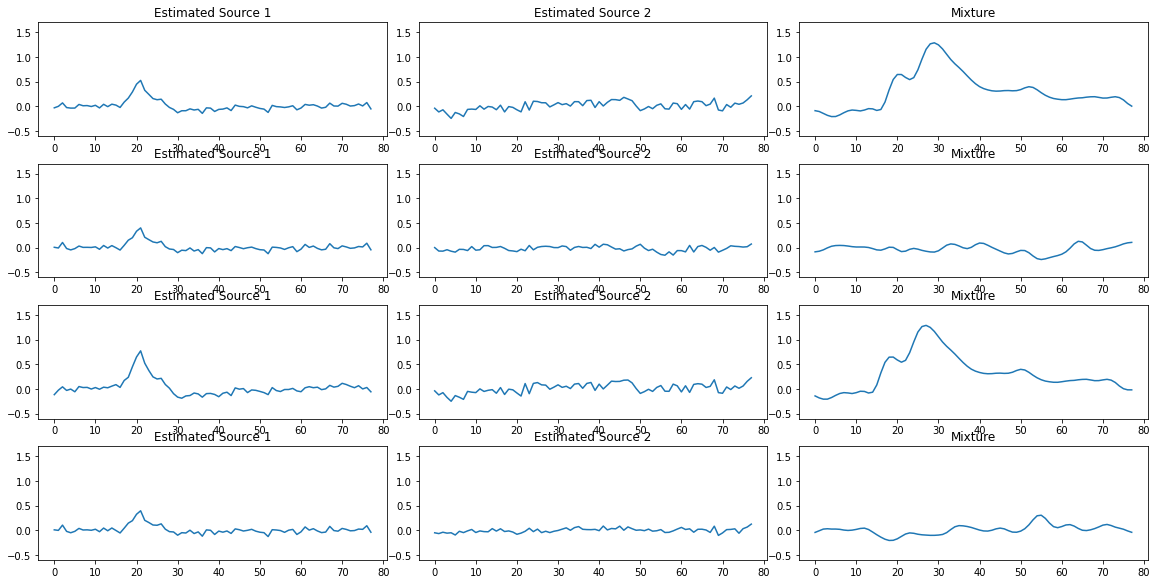

In [193]:
# separates the samples from loader_mix_val

(cleanextractedSpikesTest,cleanextractedNoisesTest) = sourceSeparation.maxlikelihood_separatesources(
    generators=[gen1, gen2],
    loader_mix=loader_mix_test,
    epochs=1000
)

In [195]:
test_loader=gans.getFeaturesTest(cleanextractedSpikesTest,cleanextractedNoisesTest)
labels=[1,1,1,1,1,0,0,0,0]*20


tensor([2.4922, 0.5839, 1.5116])
tensor([0.5839, 1.5116, 2.9255])
tensor([1.5116, 2.9255, 0.6298])
tensor([2.9255, 0.6298, 1.9160])
tensor([0.6298, 1.9160, 3.4161])
tensor([1.9160, 3.4161, 0.7542])
tensor([3.4161, 0.7542, 2.8738])
tensor([0.7542, 2.8738, 4.0191])
tensor([2.8738, 4.0191, 0.9265])
tensor([4.0191, 0.9265, 3.8727])
tensor([0.9265, 3.8727, 4.4492])
tensor([3.8727, 4.4492, 1.0952])
tensor([4.4492, 1.0952, 4.7368])
tensor([1.0952, 4.7368, 5.3389])
tensor([4.7368, 5.3389, 0.7373])
tensor([5.3389, 0.7373, 2.1463])
tensor([0.7373, 2.1463, 5.3394])
tensor([2.1463, 5.3394, 0.7960])
tensor([5.3394, 0.7960, 2.2614])
tensor([0.7960, 2.2614, 5.5290])
tensor([2.2614, 5.5290, 0.8006])
tensor([5.5290, 0.8006, 2.4541])
tensor([0.8006, 2.4541, 5.1126])
tensor([2.4541, 5.1126, 0.8082])
tensor([5.1126, 0.8082, 2.4934])
tensor([0.8082, 2.4934, 3.4338])
tensor([2.4934, 3.4338, 0.8992])
tensor([3.4338, 0.8992, 1.5028])
tensor([0.8992, 1.5028, 2.7280])
tensor([1.5028, 2.7280, 0.6411])
tensor([2.

In [201]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]


[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0]


In [197]:
confusion_matrix(labels, y_pred_list)

array([[61, 19],
       [71, 29]], dtype=int64)

In [199]:
print(classification_report(labels, y_pred_list))

              precision    recall  f1-score   support

           0       0.46      0.76      0.58        80
           1       0.60      0.29      0.39       100

    accuracy                           0.50       180
   macro avg       0.53      0.53      0.48       180
weighted avg       0.54      0.50      0.47       180

